In [1]:
# univariate multi-step vector-output 1d cnn example
from numpy import array
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
import pandas as pd

from math import log
from math import exp
from scipy.stats import boxcox

In [2]:
# split a univariate sequence into samples
def split_sequence(sequence, n_steps_in, n_steps_out):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps_in
		out_end_ix = end_ix + n_steps_out
		# check if we are beyond the sequence
		if out_end_ix > len(sequence):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)

In [3]:
# invert a boxcox transform for one value
def invert_boxcox(value, lam):
	# log case
	if lam == 0:
		return exp(value)
	# all other cases
	return exp(log(lam * value + 1) / lam)

In [176]:
data = pd.read_csv("Timeseries_real_data_interview.csv")
t = data.iloc[0:11964] #11565
v = data.iloc[11964:19940]
ts = data.iloc[19940:20001]
# define input sequence
train_seq = t['Value'].values
val_seq = v['Value'].values
test_seq = ts['Value'].values

tr, tr_lamb = boxcox(train_seq)
vl, vl_lamb = boxcox(val_seq)
ts, ts_lamb = boxcox(test_seq)

print('Training Sequence : %d'%len(train_seq))
print('Validation Sequence : %d'%len(val_seq))
print('Testing Sequence : %d'%len(test_seq))

Training Sequence : 11964
Validation Sequence : 7976
Testing Sequence : 60


In [177]:
# choose a number of time steps
n_steps_in, n_steps_out = 30, 30
# split into samples
X_train, y_train = split_sequence(tr, n_steps_in, n_steps_out)
X_val, y_val = split_sequence(vl, n_steps_in, n_steps_out)
X_test, y_test = split_sequence(ts, n_steps_in, n_steps_out)
# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))
X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], n_features))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], n_features))

In [178]:
# define model
import keras.backend as kb

def r2_score(y_true, y_pred):
    ss_res = kb.sum(kb.square(y_true - y_pred))
    ss_tot = kb.sum(kb.square(y_true - kb.mean(y_true)))
    return (1 - ss_res/(ss_tot + kb.epsilon()))

model = Sequential()
model.add(Conv1D(filters=126, kernel_size=2, activation='tanh', input_shape=(n_steps_in, n_features), kernel_regularizer=keras.regularizers.l2(l=0.01), kernel_initializer='he_normal'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dropout(0.2))
model.add(Dense(n_steps_out))

adam = keras.optimizers.Adam(lr=0.001)
model.compile(optimizer=adam, loss='mse', metrics=[r2_score, 'mae', keras.metrics.RootMeanSquaredError()])

In [179]:
# fit model
history = model.fit(X_train, y_train, epochs=100, verbose=1, validation_data=(X_val, y_val), batch_size=64)

Epoch 1/100
187/187 [==============================] - 5s 26ms/step - loss: 41.2502 - r2_score: 0.1189 - mae: 4.7940 - root_mean_squared_error: 6.2407 - val_loss: 76.6351 - val_r2_score: -2.3904 - val_mae: 7.6510 - val_root_mean_squared_error: 8.6360
Epoch 2/100
187/187 [==============================] - 4s 21ms/step - loss: 12.7336 - r2_score: 0.7545 - mae: 2.5469 - root_mean_squared_error: 3.2968 - val_loss: 40.6675 - val_r2_score: -0.7720 - val_mae: 5.3636 - val_root_mean_squared_error: 6.2432
Epoch 3/100
187/187 [==============================] - 4s 19ms/step - loss: 10.0285 - r2_score: 0.8082 - mae: 2.1965 - root_mean_squared_error: 2.9119 - val_loss: 27.8481 - val_r2_score: -0.2032 - val_mae: 4.2434 - val_root_mean_squared_error: 5.1409
Epoch 4/100
187/187 [==============================] - 3s 18ms/step - loss: 9.0223 - r2_score: 0.8256 - mae: 2.0676 - root_mean_squared_error: 2.7765 - val_loss: 18.7779 - val_r2_score: 0.2010 - val_mae: 3.2988 - val_root_mean_squared_error: 4.190

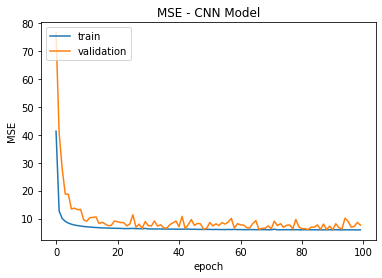

In [180]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('MSE - CNN Model')
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.savefig('saved/cnn/loss.png')
plt.show()

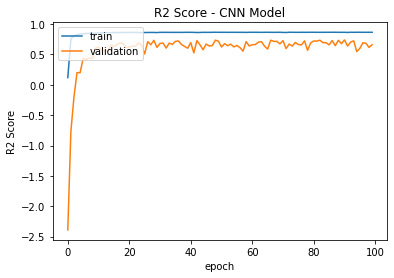

In [181]:
plt.plot(history.history['r2_score'])
plt.plot(history.history['val_r2_score'])
plt.title('R2 Score - CNN Model')
plt.ylabel('R2 Score')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.savefig('saved/cnn/r2_score.png')
plt.show()

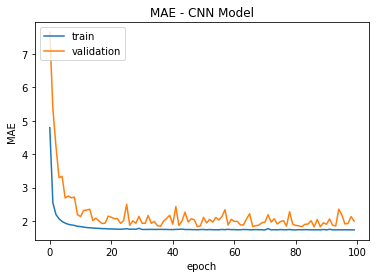

In [182]:
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('MAE - CNN Model')
plt.ylabel('MAE')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.savefig('saved/cnn/mae.png')
plt.show()

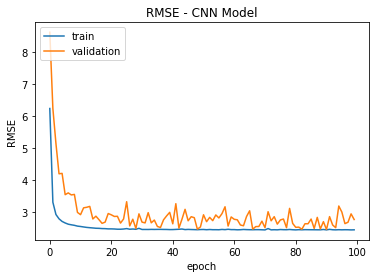

In [183]:
plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])
plt.title('RMSE - CNN Model')
plt.ylabel('RMSE')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.savefig('saved/cnn/rmse.png')
plt.show()

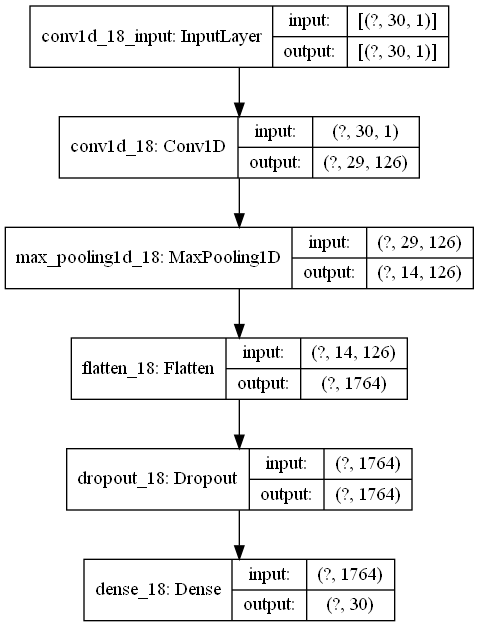

In [184]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='saved/cnn/model.png', show_shapes=True, show_layer_names=True)

In [185]:
print(model.summary())

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_18 (Conv1D)           (None, 29, 126)           378       
_________________________________________________________________
max_pooling1d_18 (MaxPooling (None, 14, 126)           0         
_________________________________________________________________
flatten_18 (Flatten)         (None, 1764)              0         
_________________________________________________________________
dropout_18 (Dropout)         (None, 1764)              0         
_________________________________________________________________
dense_18 (Dense)             (None, 30)                52950     
Total params: 53,328
Trainable params: 53,328
Non-trainable params: 0
_________________________________________________________________
None


In [186]:
hist_df = pd.DataFrame(history.history) 
hist_csv_file = 'saved/cnn/history.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

In [187]:
prediction = model.predict(X_test, verbose=0)

In [188]:
from sklearn.metrics import mean_squared_error, r2_score
mse = mean_squared_error(prediction, y_test)
r2 = r2_score(prediction[0], y_test[0])
print('Predicted MSE : %s'%mse)
print('Predicted R2 Score : %s'%r2)

Predicted MSE : 1.0413548062974043
Predicted R2 Score : 0.6484340006620677


In [189]:
y_test[0]

array([14.75274718, 14.52532563, 14.43978398, 14.73415866, 14.93712005,
       16.31742387, 15.99903992, 15.45547817, 15.7767913 , 16.99510365,
       17.62197755, 17.53821249, 18.05517037, 17.95538347, 18.22478739,
       19.54693849, 19.18823898, 20.35027236, 19.03428519, 19.34392341,
       19.34553527, 18.50742023, 18.4990102 , 17.58222371, 18.34088583,
       16.5565262 , 16.17991096, 15.69968205, 15.58516797, 15.29423038])

In [190]:
prediction[0]

array([15.693191, 15.096613, 15.459937, 15.756039, 15.561147, 16.450756,
       15.702071, 16.379715, 17.060564, 17.509077, 17.597393, 18.398813,
       18.316305, 18.717337, 19.570261, 20.395449, 20.123568, 20.279127,
       20.992294, 19.857874, 19.913418, 19.91884 , 19.252468, 18.382038,
       18.375439, 18.665268, 17.873308, 17.46976 , 16.360237, 16.395798],
      dtype=float32)

<BarContainer object of 30 artists>

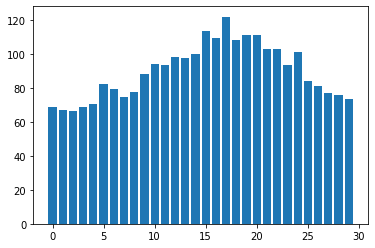

In [191]:
x = np.arange(30)
y_test_invert = []

# Inverse Box-Cox Transform
for i in range(len(y_test[0])):
    y_test_invert.append(invert_boxcox(y_test[0][i], ts_lamb))
plt.bar(x, y_test_invert)

<BarContainer object of 30 artists>

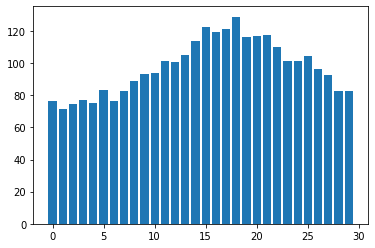

In [192]:
x = np.arange(30)
y_prediction_invert = []

# Inverse Box-Cox Transform
for i in range(len(y_test[0])):
    y_prediction_invert.append(invert_boxcox(prediction[0][i], ts_lamb))
plt.bar(x, y_prediction_invert)

In [193]:
from sklearn.metrics import mean_squared_error, r2_score
mse = mean_squared_error(y_prediction_invert, y_test_invert)
r2 = r2_score(y_prediction_invert, y_test_invert)
print('Predicted MSE : %s'%mse)
print('Predicted R2 Score : %s'%r2)

Predicted MSE : 94.83848285813048
Predicted R2 Score : 0.6575378111534304


In [194]:
y_prediction_invert

[76.5937254238927,
 71.55177345701351,
 74.60212886479772,
 77.13479239343161,
 75.46309569105773,
 83.24147981148964,
 76.67006516948351,
 82.60642940014968,
 88.79183916623253,
 92.98745776918369,
 93.82492647601825,
 101.59464072393992,
 100.78058093049138,
 104.76778963132047,
 113.5028624425338,
 122.28381762956276,
 119.35485643354808,
 121.0263822697092,
 128.83705747272364,
 116.52656927917063,
 117.11504919032062,
 117.17257955204983,
 110.2077111909813,
 101.42886718085938,
 101.36368777215306,
 104.24576984942993,
 96.46531302904297,
 92.61583411593898,
 82.43273432688942,
 82.74998522933227]

In [195]:
y_test_invert

[68.7229498558514,
 66.88314403489694,
 66.19753176817476,
 68.57164266251183,
 70.2326649574087,
 82.05158118122326,
 79.24458484836387,
 74.56431045526703,
 77.31386907748917,
 88.18752142535003,
 94.05871505735975,
 93.2633270464537,
 98.22551788565214,
 97.25774811541993,
 99.8814262747274,
 113.25939803090051,
 109.54757547020331,
 121.7946965426342,
 107.97327128356129,
 111.15106604868612,
 111.16772796285335,
 102.67115334375592,
 102.58759224070153,
 93.68081636735795,
 101.02276466165708,
 84.19144718319225,
 80.83327099203122,
 76.64952386758928,
 75.66815798045012,
 73.20307621397502]

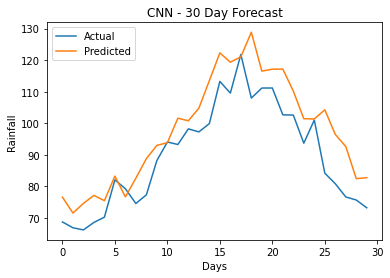

In [4]:
plt.plot(y_test_invert)
plt.plot(y_prediction_invert)
plt.title('CNN - 30 Day Forecast')
plt.ylabel('Rainfall')
plt.xlabel('Days')
plt.legend(['Actual', 'Predicted'], loc='upper left')
plt.savefig('saved/cnn/test.png')
plt.show()